# Echo State Network
Here, we validate the hyperparameters of the ESN. Note that the ESN is only trained on the encoded latent space representation. 

In [ ]:
import matplotlib as mpl
import pickle
import json
from pathlib import Path
import torch
import sys
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
device = torch.device("cpu")
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')

sys.path.append('../')
from src.neuralnetwork.autoencoder.cae_ks_l22 import CAE
from src.neuralnetwork.preprocessing import generate_esn_noise_data, train_valid_test_split

sys.path.insert(0, '../../EchoStateNetwork/') # you need to get the git repo https://github.com/MagriLab/EchoStateNetwork
from esn.esn import ESN
from esn.validation import validate
from esn.utils import errors, scalers

#### 1: Load the trained CAE and the encoded time series

In [29]:
model_path = Path('../weights/fluent-sweep-2/')
with open(model_path/'ks.json') as f:
    ks_data = json.load(f)
print(ks_data)
# Define some parameters for the data
# Define some parameters for the data
N_lyap = int(1/0.08/0.05)

N_lyap = int(1/ks_data["lyap"]/ks_data["dt"])
with open(model_path /'encoded_ks.npy', 'rb') as f:
    U_encoded = np.load(f)
print(f"Encoded timeseries {U_encoded.shape}")

{'upsample': 4, 'L': 22, 'N_data': 400000, 'N_trans': 1000, 'dt': 0.05, 'Nx': 512, 'train_ratio': 0.8, 'valid_ratio': 0.1, 'batchsize': 128, 'normtype': 'max', 'lyap': 0.04}
Encoded timeseries (399801, 8)


#### 2: Prepare the encoded data for the ESN training

In [30]:
U_esn = generate_esn_noise_data(U_encoded, 1, sigma_n=1e-3)
u_encoded_train, u_encoded_valid, u_encoded_test = train_valid_test_split(U_esn, ks_data)

In [31]:
total_samples, dim = u_encoded_train.shape
N_washout = 200
train_size = min(len(u_encoded_train)-N_washout-101, 100000)#-1001
val_size = min(len(u_encoded_valid)-101-N_washout, 20001)
test_N_washout = 100
# Split the data into different datasets
U_washout = u_encoded_train[:N_washout, ...]
U_train_input = u_encoded_train[N_washout:N_washout+train_size-1, ...]
U_train_label = u_encoded_train[N_washout + 1:N_washout+train_size, ...]
U_val_input = u_encoded_valid[:val_size-1, ...]
U_val_label = u_encoded_valid[1:val_size, ...]
U_test_washout = u_encoded_test[:test_N_washout, ...]
U_test = u_encoded_test[N_washout:, ...]
# Print shapes of datasets
print(f"Training data shape: {U_train_input.shape, U_train_label.shape}")
print(f"U_val shape: {U_val_input.shape, U_val_label.shape}")
print(f"U_test shape: {U_test.shape}")

Training data shape: ((99999, 8), (99999, 8))
U_val shape: ((20000, 8), (20000, 8))
U_test shape: (39601, 8)


#### 3: Validate the hyperparameters of the ESN

In [54]:
#  specify which hyperparameters to search, e.g., spectral_radius, input_scaling, leak_factor
hyperparameter_dict = {
    'spectral_radius': [0.1, 1.0, 'uniform'],
    'input_scaling': [0.01, 10.0, 'log10'],
    'tikhonov': [1e-12, 1e-3, 'log10'],
    # 'leak_factor': [0.1, 1.0, 'uniform']  # Uncomment if needed
}
grid_range = []
for i, parameter in enumerate(hyperparameter_dict.keys()):
    scaler = getattr(scalers, hyperparameter_dict[parameter][-1])
    grid_range.append(scaler(hyperparameter_dict[parameter][:2]))

# compute normalization factor (range component-wise)
U_data = U_esn[:N_washout+train_size, :dim].copy()
m = U_data.min(axis=0)
M = U_data.max(axis=0)
norm = M-m
u_mean = U_data.mean(axis=0)

N_val = 1000  # number of validation steps

# fixed properties of the ESN
ESN_dict = {'reservoir_size': 5000,
        'dimension': dim,
        'reservoir_connectivity': 10,
        # np.array([np.mean(np.abs((U_data-u_mean)/norm))]),
        'input_bias': np.array([1]),
        # np.array([np.mean(np.abs((U_data-u_mean)/norm))]*2),
        'output_bias':  np.array([0]),
        'reservoir_weights_mode': "erdos_renyi1",
        # 'tikhonov': 1e-10,
        'input_normalization': [u_mean, norm],
        # 'input_weights_mode': 'dense',
        'input_seeds':[0, 1, 2],
        'reservoir_seeds':[3, 4]
    }


min_dict = validate(
    grid_range=grid_range,
    param_names=[key for key in hyperparameter_dict.keys()],
    param_scales=[values[-1] for values in hyperparameter_dict.values()],
    n_calls=20,  # number of total trials
    n_initial_points=10,  # number of initial trials before bayesian optimization
    ESN_dict=ESN_dict,
    U_washout_train=U_washout,
    n_realisations=1,  # number of random ESN realisations
    U_train=U_train_input,
    Y_train=U_train_label,
    U_val=U_val_input,
    Y_val=U_val_label,
    n_folds=5,  # number of folds, i.e., validation time series that start from random time instances
    N_washout_steps=N_washout,
    N_val_steps=N_val,
    random_seed=10,  # random seed for the bayesian optimization
    error_measure=errors.rel_L2)  # error measure to optimize over

esn_loaded_dict = dict(min_dict, **ESN_dict)

Input to run_gp:([Real(low=0.1, high=1.0, prior='uniform', transform='identity'), Real(low=-2.0, high=1.0, prior='uniform', transform='identity'), Integer(low=-12.0, high=-3.0, prior='uniform', transform='identity')], 20, 10, 10)
--NEW RUN-- 1
Realisation: 0
spectral_radius 0.6335601564025166
input_scaling 3.41033659841376
tikhonov 9.999999999999999e-05


Val regime: 0
Fold: 0 , fold error:  1.1228877716263268
Fold: 1 , fold error:  0.9359268393596284
Fold: 2 , fold error:  1.1237655911900923
Fold: 3 , fold error:  1.0925937026394958
Fold: 4 , fold error:  1.1295332137941914
Val regime error: 1.080941423721947
Realisation error: 1.080941423721947


Run 1 error: 1.080941423721947


--NEW RUN-- 2
Realisation: 0
spectral_radius 0.8625265649057131
input_scaling 0.7424908231815013
tikhonov 9.999999999999999e-10




/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.40324e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  0.8027451595065188
Fold: 1 , fold error:  1.1934537663746978
Fold: 2 , fold error:  0.5822024926061193
Fold: 3 , fold error:  0.9491909598926414
Fold: 4 , fold error:  1.1871701351895267
Val regime error: 0.9429525027139007
Realisation error: 0.9429525027139007


Run 2 error: 0.9429525027139007


--NEW RUN-- 3
Realisation: 0
spectral_radius 0.3677811458900251
input_scaling 0.014795816345422881
tikhonov 9.999999999999999e-11


Val regime: 0
Fold: 0 , fold error:  1.1268481902179648
Fold: 1 , fold error:  0.9225604386516572
Fold: 2 , fold error:  1.1153037192389677
Fold: 3 , fold error:  0.9324080270135296
Fold: 4 , fold error:  1.1727435767225514
Val regime error: 1.0539727903689342
Realisation error: 1.0539727903689342


Run 3 error: 1.0539727903689342


--NEW RUN-- 4
Realisation: 0
spectral_radius 0.529898605589215
input_scaling 2.732160361977424
tikhonov 1e-08




/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.83845e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  1.2479597034584018
Fold: 1 , fold error:  1.2026892035832226
Fold: 2 , fold error:  1.0808943368125237
Fold: 3 , fold error:  0.8559615609303712
Fold: 4 , fold error:  1.2243945925367379
Val regime error: 1.1223798794642514
Realisation error: 1.1223798794642514


Run 4 error: 1.1223798794642514


--NEW RUN-- 5
Realisation: 0
spectral_radius 0.4535063164907469
input_scaling 3.2228217847874103
tikhonov 9.999999999999999e-10




/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.94051e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  0.7509284482347744
Fold: 1 , fold error:  0.9559423412713113
Fold: 2 , fold error:  0.9792911434238849
Fold: 3 , fold error:  1.305110570779785
Fold: 4 , fold error:  1.0946373400452507
Val regime error: 1.0171819687510013
Realisation error: 1.0171819687510013


Run 5 error: 1.0171819687510013


--NEW RUN-- 6
Realisation: 0
spectral_radius 0.6833546848460775
input_scaling 0.12726958252506762
tikhonov 0.001


Val regime: 0
Fold: 0 , fold error:  1.0034751692407688
Fold: 1 , fold error:  1.0119451083266249
Fold: 2 , fold error:  0.9258111026190925
Fold: 3 , fold error:  0.9146456608361073
Fold: 4 , fold error:  0.9191750899101214
Val regime error: 0.955010426186543
Realisation error: 0.955010426186543


Run 6 error: 0.955010426186543


--NEW RUN-- 7
Realisation: 0
spectral_radius 0.22631570237138066
input_scaling 4.076259041096254
tikhonov 1e-08




/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.28549e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  1.1374973113330693
Fold: 1 , fold error:  1.0477594586184067
Fold: 2 , fold error:  1.0106050845765828
Fold: 3 , fold error:  0.9412483314091139
Fold: 4 , fold error:  1.0429437077578148
Val regime error: 1.0360107787389974
Realisation error: 1.0360107787389974


Run 7 error: 1.0360107787389974


--NEW RUN-- 8
Realisation: 0
spectral_radius 0.82081967678168
input_scaling 0.3642775765463243
tikhonov 1e-06


Val regime: 0
Fold: 0 , fold error:  1.2460537471354105
Fold: 1 , fold error:  1.1850837096797044
Fold: 2 , fold error:  1.086981835836231
Fold: 3 , fold error:  1.2283514166772782
Fold: 4 , fold error:  0.9943718066099112
Val regime error: 1.1481685031877071
Realisation error: 1.1481685031877071


Run 8 error: 1.1481685031877071


--NEW RUN-- 9
Realisation: 0
spectral_radius 0.7485693892533252
input_scaling 0.5572619319129042
tikhonov 1e-07


Val regime: 0
Fold: 0 , fold error:  1.0879156907032819
Fold: 1 , fold error:  1.2029852855865935
Fold: 2

/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.08854e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  0.9192119720017863
Fold: 1 , fold error:  0.9454657380090111
Fold: 2 , fold error:  260066.87301686447
Fold: 3 , fold error:  1.0783930989017574
Fold: 4 , fold error:  1.1035239827475016
Val regime error: 52014.18392233123
Realisation error: 52014.18392233123


Run 11 error: 52014.18392233123


--NEW RUN-- 12
Realisation: 0
spectral_radius 1.0
input_scaling 10.0
tikhonov 9.999999999999999e-06


Val regime: 0
Fold: 0 , fold error:  1.4621714061874806
Fold: 1 , fold error:  1.1857522255202377
Fold: 2 , fold error:  1.4269682366051284
Fold: 3 , fold error:  1.2662019373553737
Fold: 4 , fold error:  1.3103194746602944
Val regime error: 1.3302826560657028
Realisation error: 1.3302826560657028


Run 12 error: 1.3302826560657028


--NEW RUN-- 13
Realisation: 0
spectral_radius 1.0
input_scaling 10.0
tikhonov 1e-08




/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.81397e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  1.1339865923714634
Fold: 1 , fold error:  1.171144897172496
Fold: 2 , fold error:  1.3068463101740666
Fold: 3 , fold error:  1.5143833523265138
Fold: 4 , fold error:  1.3375856094645207
Val regime error: 1.2927893523018121
Realisation error: 1.2927893523018121


Run 13 error: 1.2927893523018121


--NEW RUN-- 14
Realisation: 0
spectral_radius 0.1
input_scaling 0.01
tikhonov 9.999999999999999e-06


Val regime: 0
Fold: 0 , fold error:  1.0193393926032746
Fold: 1 , fold error:  1.1193135529332237
Fold: 2 , fold error:  1.0153411962575152
Fold: 3 , fold error:  1.0137707350248468
Fold: 4 , fold error:  0.9962446294230748
Val regime error: 1.032801901248387
Realisation error: 1.032801901248387


Run 14 error: 1.032801901248387


--NEW RUN-- 15
Realisation: 0
spectral_radius 1.0
input_scaling 10.0
tikhonov 9.999999999999999e-11


Val regime: 0
Fold: 0 , fold error:  1.2105370112931009
Fold: 1 , fold error:  1.3881230667713056
Fold: 2 , fold error:  1.51180

In [55]:
# with open(model_path / 'esn_best_dict.pkl', 'wb') as f:
#     pickle.dump(esn_loaded_dict, f)

#### 4: Select the best ESN hyperparameters
We provide hyperparameters from the ESN that we validated. 

In [56]:
# with open(cae_path / 'esn_best_dict.pkl', 'rb') as f:
#     esn_loaded_dict = pickle.load(f)

print(f"Dictionary loaded in {esn_loaded_dict}")
i=0
my_ESN = ESN(reservoir_size=esn_loaded_dict["reservoir_size"],
                dimension=esn_loaded_dict["dimension"],
                reservoir_connectivity=esn_loaded_dict["reservoir_connectivity"],
                spectral_radius=esn_loaded_dict['spectral_radius'][i],
                input_scaling=esn_loaded_dict['input_scaling'][i],
                tikhonov=esn_loaded_dict['tikhonov'][i],
                input_bias=esn_loaded_dict["input_bias"],
                output_bias=esn_loaded_dict["output_bias"],
                reservoir_weights_mode=esn_loaded_dict['reservoir_weights_mode'],
                input_normalization=esn_loaded_dict['input_normalization'],
                # input_weights_mode=esn_loaded_dict['input_weights_mode'],
                #   leak_factor =min_dict['leak_factor'][i],
                input_seeds=esn_loaded_dict["input_seeds"],
                reservoir_seeds=esn_loaded_dict["reservoir_seeds"], verbose=False)
my_ESN.train(U_washout, U_train_input, U_train_label)

Dictionary loaded in {'f': array([0.9429525 , 0.95501043, 1.01718197, 1.0328019 , 1.03601078]), 'spectral_radius': array([0.86252656, 0.68335468, 0.45350632, 0.1       , 0.2263157 ]), 'input_scaling': array([0.74249082, 0.12726958, 3.22282178, 0.01      , 4.07625904]), 'tikhonov': array([1.e-09, 1.e-03, 1.e-09, 1.e-05, 1.e-08]), 'reservoir_size': 5000, 'dimension': 8, 'reservoir_connectivity': 10, 'input_bias': array([1]), 'output_bias': array([0]), 'reservoir_weights_mode': 'erdos_renyi1', 'input_normalization': [array([-0.00593858, -0.04789577,  0.01191856,  0.03158609, -0.03616858,
        0.04105314, -0.00360776,  0.01144325]), array([1.11553235, 1.08183018, 1.10016882, 1.06189767, 1.08552729,
       1.07920115, 1.16133172, 1.06537837])], 'input_seeds': [0, 1, 2], 'reservoir_seeds': [3, 4]}


/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.43606e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


#### 5: CAE-ESN prediction on the test data

In [57]:
cae_model = CAE(8)
cae_model.load_state_dict(torch.load(model_path/"best_model.pth", map_location=device))
cae_model = cae_model.to(device)

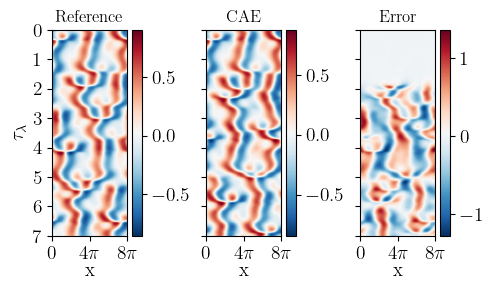

In [58]:

# Define constants
N_lyap = int(1/ks_data["lyap"]/((ks_data["dt"])*ks_data["upsample"]))
N_plot = 7*N_lyap
fs = 14
cmap = 'RdBu_r'

# Calculate domain length
domain_length = 20 * np.pi

# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(5,3), sharey=True)  # Changed ncols to 1

N_start = 200 
reservoir, prediction = my_ESN.closed_loop_with_washout(u_encoded_test[N_start:N_start+N_washout, :dim], N_plot)
snapshot_decoded = cae_model.decoder(torch.from_numpy(prediction).float().to(device)).numpy(force=True)
snapshot = cae_model.decoder(torch.from_numpy( u_encoded_test[N_start+N_washout:N_start+N_washout+N_plot, :dim]).float().to(device)).numpy(force=True)


# Extract data
data1 = snapshot[:N_plot, 0, :] 
data2 = snapshot_decoded[:N_plot, 0, :] 
data3 = data1 - data2

lyapunov_time = ks_data["lyap"] * np.arange(0, 10000, (((ks_data["dt"])*ks_data["upsample"])))
# Adjust subplot spacing
plt.subplots_adjust(wspace=-0.05)  #
# Plot data
for i, data in enumerate([data1, data2, data3]):
    axes = axs[i]
    im = axes.imshow(data, aspect='auto', cmap=cmap,
                     extent=[0, 2 * 4 * np.pi, int(lyapunov_time[N_plot]), lyapunov_time[0]])


    axes.set_xlabel('x', fontsize=fs, rotation=0, labelpad=0, y=0.46)
     # Set y-tick labels and font size
    axes.set_yticks(axes.get_yticks())  # Ensure yticks are set first
    axes.set_yticklabels([f'{int(tick)}' for tick in axes.get_yticks()], fontsize=fs)

    axes.yaxis.tick_left()
    axes.set_xticks(np.arange(0, 8 * np.pi + 0.01, step=(1 * 4 * np.pi)), ['0', r'$4\pi$', r'8$\pi$'],
                    fontsize=fs)
    for tick_label in axes.get_xticklabels():
        tick_label.set_ha('center')
        tick_label.set_x(-0.05)

    cbar = fig.colorbar(im, ax=axes)
    cbar.ax.tick_params(labelsize=fs)

axs[0].set_ylabel(r'$\tau_{\lambda}$', fontsize=fs)
axs[0].set_title("Reference")
axs[1].set_title("CAE")
axs[2].set_title("Error")
# Show or save plot
plt.tight_layout()
# plt.savefig("../images/cae-esn.png", dpi=100)
